<a href="https://www.kaggle.com/fernandojunior2106/titanic-ml-project?scriptVersionId=88954390" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 0. Setup

In [3]:
!pip install --upgrade plotly

     |████████████████████████████████| 27.7 MB 4.4 MB/s eta 0:00:01    |██▎                             | 1.9 MB 4.4 MB/s eta 0:00:06
  Attempting uninstall: tenacity
    Found existing installation: tenacity 6.1.0
    Uninstalling tenacity-6.1.0:
      Successfully uninstalled tenacity-6.1.0
  Attempting uninstall: plotly
    Found existing installation: plotly 4.7.1
    Uninstalling plotly-4.7.1:
      Successfully uninstalled plotly-4.7.1
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [162]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
import time

# Classification Models
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.svm import SVC # SVM
from sklearn.ensemble import RandomForestClassifier # RandomForest
from sklearn.naive_bayes import GaussianNB # Naive Bayes
from xgboost import XGBClassifier # Xgboost

# Regressor models
from sklearn.ensemble import RandomForestRegressor

# Pre Processing Functions
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer # handle missing values (naive approach)
from sklearn.impute import KNNImputer # handle missing values (better approach)
from sklearn.preprocessing import OneHotEncoder # enconding cat variables
from sklearn.preprocessing import MinMaxScaler # normale (values betwenn 0 and 1)
from sklearn.preprocessing import StandardScaler # standardize (center the data around 0)
from sklearn.decomposition import PCA, TruncatedSVD # Principal Components Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA # Linear Discriminant Analysis

# Evaluate classification models
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_validate, cross_val_score

# Tune models
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV

# Statistics functions
from scipy.stats import randint
from scipy.stats import uniform

# bayesian optimization
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll.base import scope

In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# 1. Import and describe data

In [6]:
# Seed
seed = 42

# Read Data Sets
df = pd.read_csv("/kaggle/input/titanic/train.csv")
submission_df = pd.read_csv("/kaggle/input/titanic/test.csv")
ids = pd.read_csv("/kaggle/input/titanic/test.csv")

In [7]:
# Look at data
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Data Dictionary**

| Variable | Description | Details |
| --- | --- | --- |
| survival | Survival | 0 = No; 1 = Yes |
| pclass | Passenger Class | 1 = 1st; 2 = 2nd; 3 = 3rd |
| name | First and Last Name |     |
| sex | Sex |     |
| age | Age |     |
| sibsp | Number of Siblings/Spouses Aboard |     |
| parch | Number of Parents/Children Aboard |     |
| ticket | Ticket Number |     |
| fare | Passenger Fare |     |
| cabin | Cabin |     |
| embarked | Port of Embarkation | C = Cherbourg; Q = Queenstown; S = Southampton |

**Variable Notes**

`pclass`: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

`age`: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

`sibsp`: The dataset defines family relations in this way...

* Sibling = brother, sister, stepbrother, stepsister
* Spouse = husband, wife (mistresses and fiancés were ignored)

`parch`: The dataset defines family relations in this way...

* Parent = mother, father
* Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

In [8]:
# Features data type
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [9]:
# adjust features types
df['Pclass'] = df['Pclass'].astype("category")
df['Sex'] = df['Sex'].astype("category")
df['Embarked'] = df['Embarked'].astype("category")

In [10]:
# Let's drop PassengerId, since it'll be not relevant for the modeling
df.drop(['PassengerId'], inplace = True, axis=1)

In [11]:
# Numeric Features description
df.describe(include=['int64', 'float64']).T.round(2)

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.38,0.49,0.00,0.00,0.00,1.0,1.00
Age,714.0,29.70,14.53,0.42,20.12,28.00,38.0,80.00
SibSp,891.0,0.52,1.10,0.00,0.00,0.00,1.0,8.00
Parch,891.0,0.38,0.81,0.00,0.00,0.00,0.0,6.00
Fare,891.0,32.20,49.69,0.00,7.91,14.45,31.0,512.33


## 1.1 Numerical features description
---

1. The mean suvive rate is 38%;
2. The average age is 29 years with a minimum of 0.42 and a maximum of 80 years
3. Fare has a std higger than the mean value

In [12]:
# Categorical Features description
df.describe(include=['object', 'category']).T

,count,unique,top,freq
Pclass,891,3,3,491
Name,891,891,"Olsen, Mr. Henry Margido",1
Sex,891,2,male,577
Ticket,891,681,1601,7
Cabin,204,147,B96 B98,4
Embarked,889,3,S,644


## 1.2 Categorical features description
---

1. Name is unique per passenger
2. Ticket is almost unique per passanger
3. Cabin has only 204 observations from 891
4. The top embarked gate is S (Southampton)

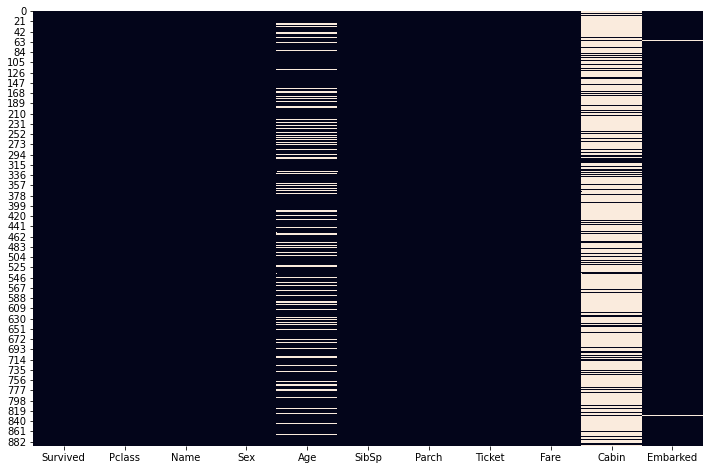

In [13]:
# Vizualizing null values
plt.figure(figsize=(12,8))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [14]:
# Total null values per feature
print(df.isnull().sum()/df.shape[0])

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64


## 1.3 Missing values
---

1. There're missing values in `Age`, `Cabin` and `Embarked`
2. Since there're only two missing values in `Embarked` we can simply input it with the most frequent class
3. `Cabin`, probably will be dropped, but let's take a look and see if we can find any interesting pattern
4. `Age` can be inputed with a regression model

# 2. Exploratory Data Analysis (EDA)

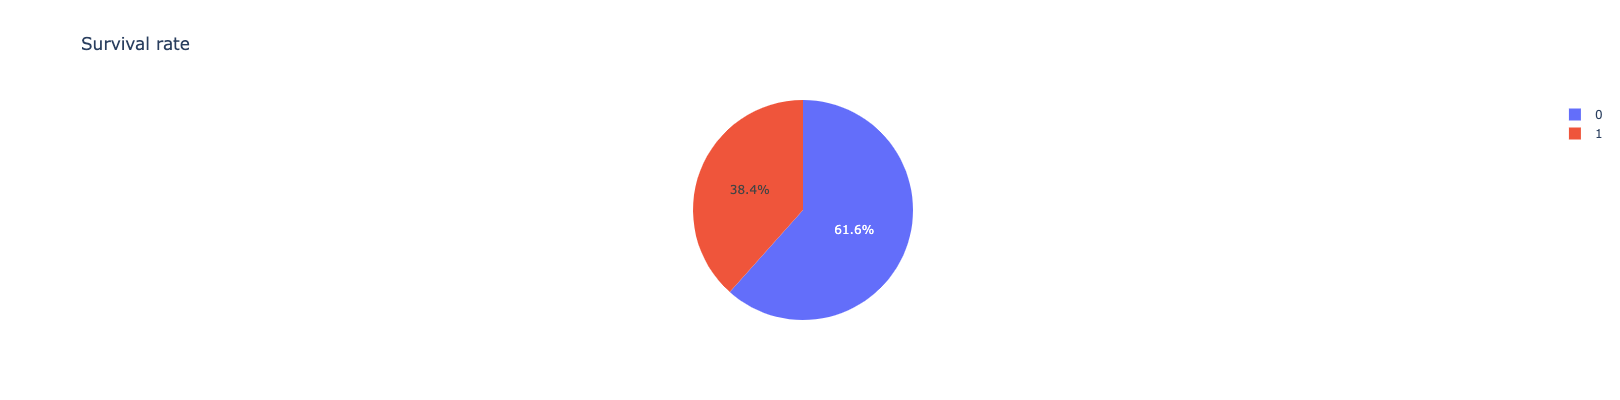

In [15]:
# Analysing target distribuition
fig = px.pie(df['Survived'], 
             values=df['Survived'].value_counts().values, 
             names=df['Survived'].value_counts().index,
             title="Survival rate", 
             width=400, height=400)
fig.show()

## 2.1 Survival rate
---

1. The survive rate is 38%

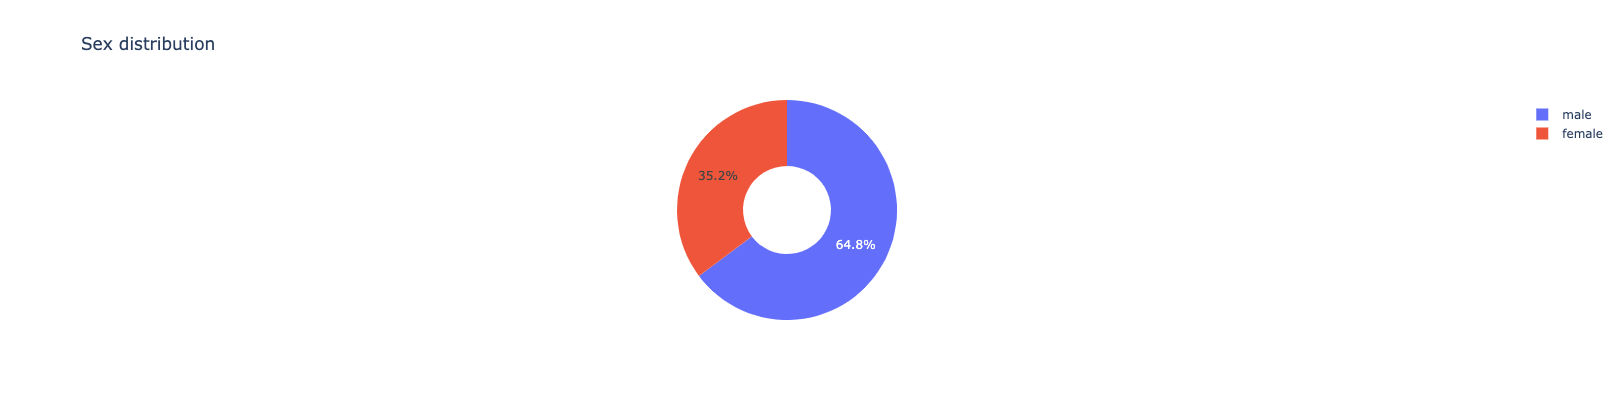

In [16]:
# Analysing sex distribuition
fig = px.pie(df['Sex'], 
             values=df['Sex'].value_counts().values, 
             names=df['Sex'].value_counts().index,
             title="Sex distribution", 
             width=400, height=400, hole=0.4)
fig.show()

## 2.2 Sex distribuition
---

1. There's was more man aboard, 64% of all passangers

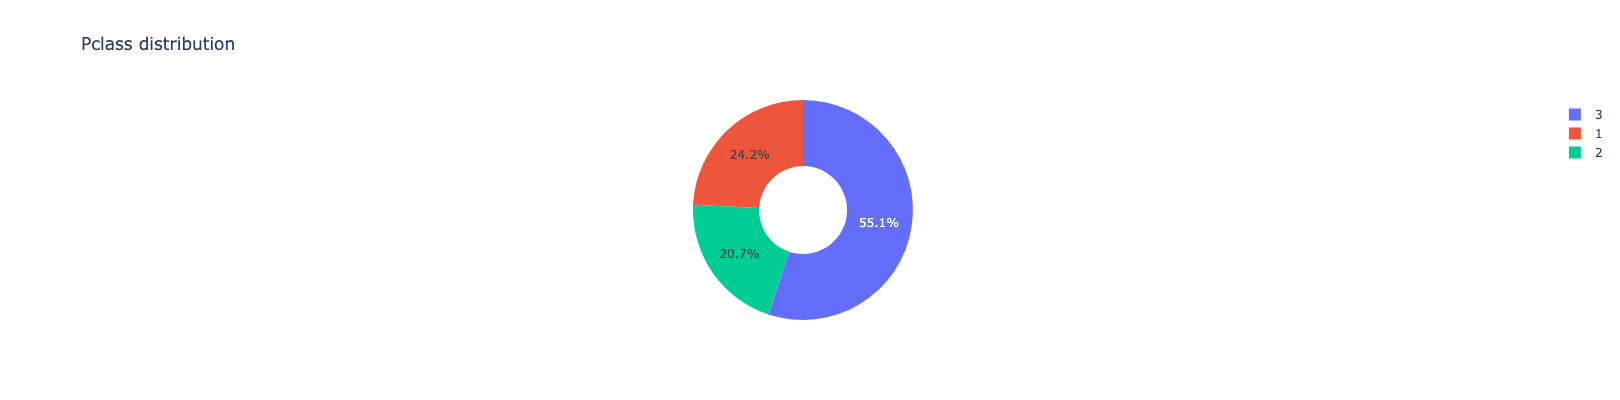

In [17]:
# Analysing Pclass distribuition
fig = px.pie(df['Pclass'], 
             values=df['Pclass'].value_counts().values, 
             names=df['Pclass'].value_counts().index,
             title="Pclass distribution", 
             width=400, height=400, hole=0.4)
fig.show()

## 2.3 Pclass distribuition
---

1. Most of the passangers were from class 3 (Lower status)

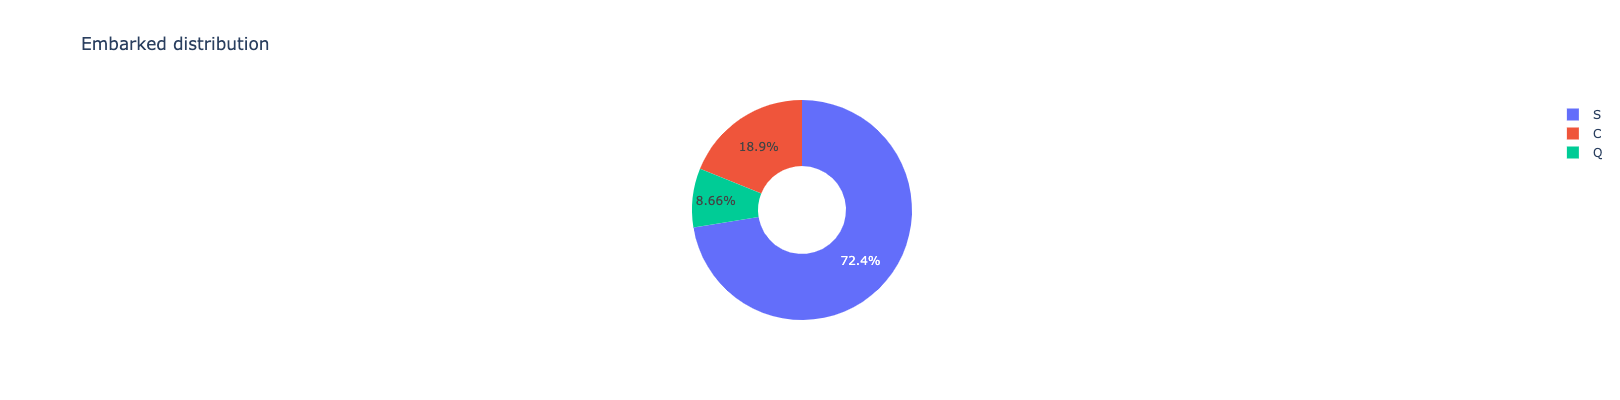

In [18]:
# Analysing Embarked distribuition
fig = px.pie(df['Embarked'], 
             values=df['Embarked'].value_counts().values, 
             names=df['Embarked'].value_counts().index,
             title="Embarked distribution", 
             width=400, height=400, hole=0.4)
fig.show()

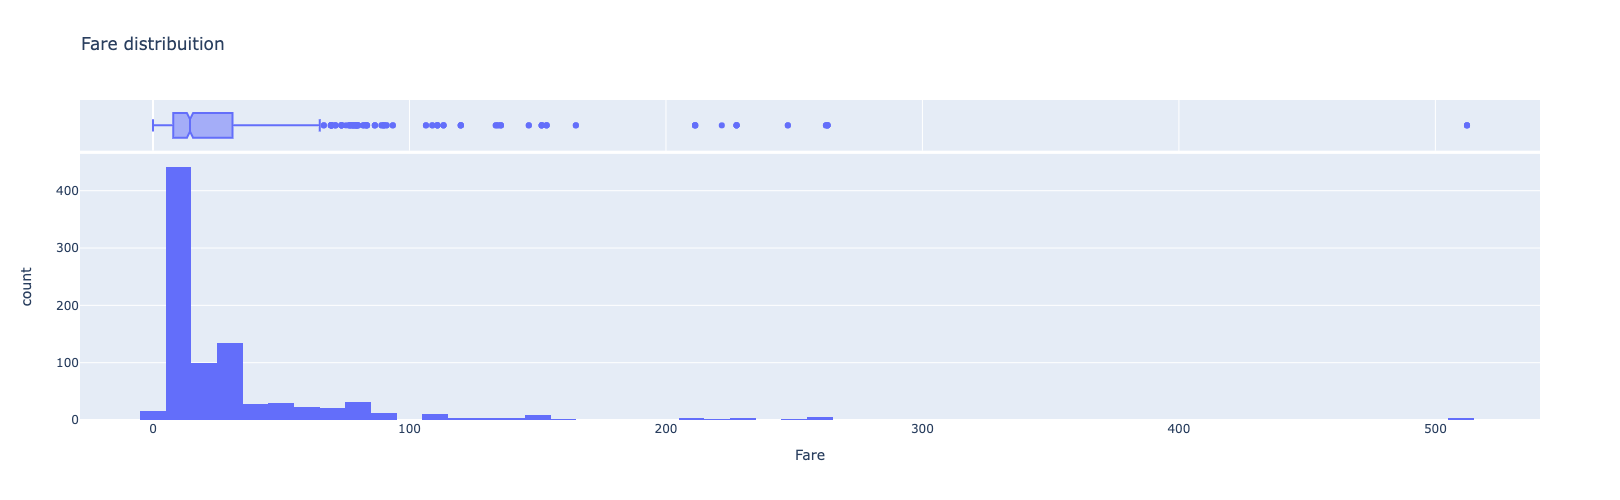

In [19]:
fig = px.histogram(df, 
                   x="Fare",
                   marginal="box", 
                   hover_data=df.columns,
                   title='Fare distribuition',
                   width=800,
                   height=500)
fig.show()

## 2.4 Fare distribuition
---

1. Fare distribuition is highly skewded, with some outliers. Let's cap Fare at 165

In [20]:
# Cap max Fare value to treat outliers
df['Fare'] = df['Fare'].clip(upper=165)

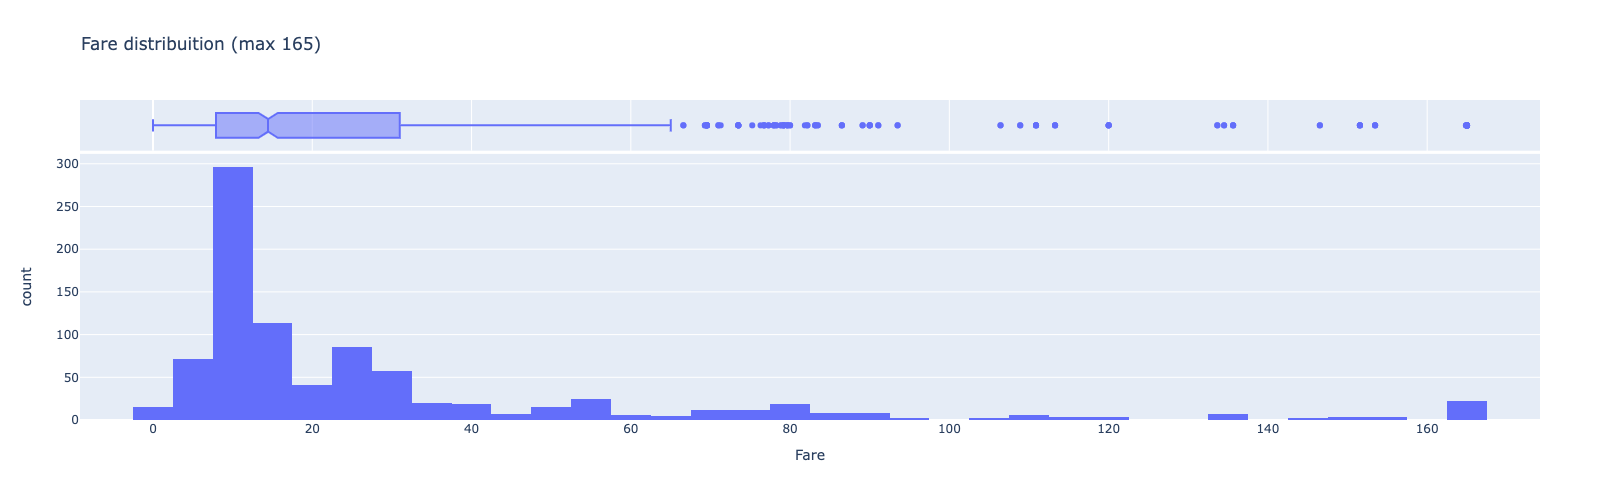

In [21]:
fig = px.histogram(df, 
                   x="Fare",
                   marginal="box", 
                   hover_data=df.columns,
                   title='Fare distribuition (max 165)',
                   width=800,
                   height=500)
fig.show()

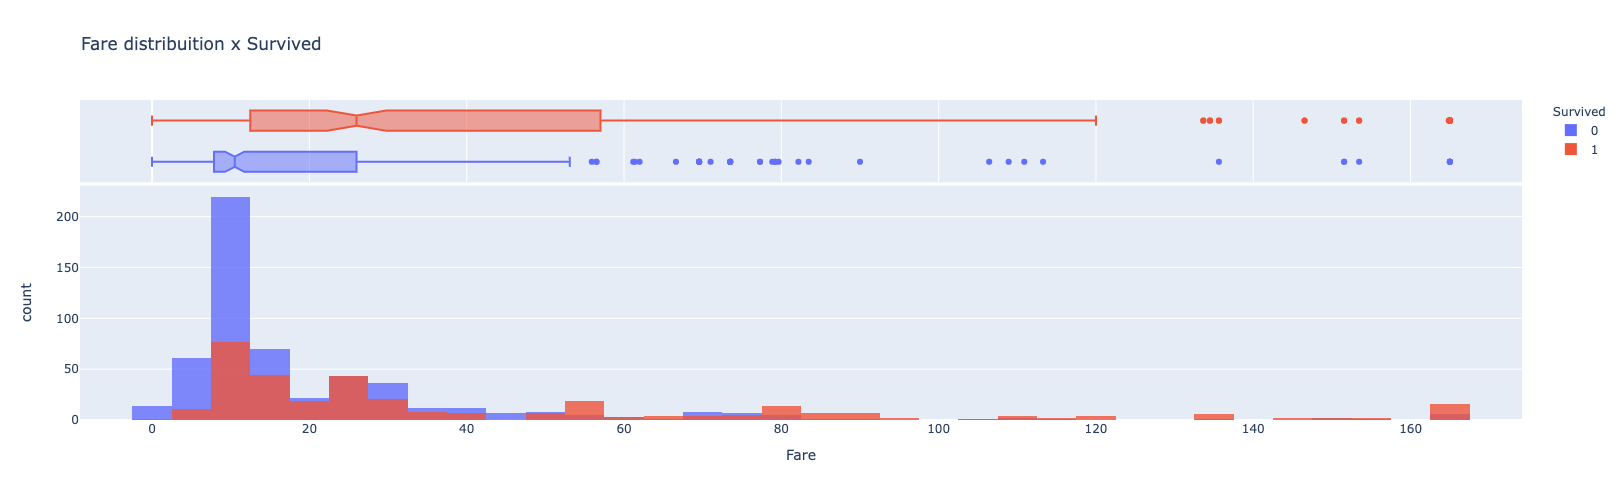

In [22]:
fig = px.histogram(df, 
                   x="Fare",
                   marginal="box", 
                   color='Survived',
                   hover_data=df.columns,
                   opacity=0.8,
                   barmode = 'overlay',
                   title='Fare distribuition x Survived',
                   width=800,
                   height=500)
fig.show()

## 2.5 Fare x Survived
---

1. There are some interesting observations from Fare x Survived
2. Fare = 0 -> All dead; Fare higgher than 100 presents higgher probability of survive; 
3. It would be better to create categories of fare ([0,1), [1,13), [13,50) [50,100), [100, 165])

In [23]:
# Feature engineering Fare
#creating the intervals that we need to cut each range of ages
interval = (0, 1, 13, 50, 100, 165) 

#Seting the names that we want use to the categorys
cats = ['Free', 'Cheap', 'Mid', 'Expensive', 'Very Expensive']

# Applying the pd.cut and using the parameters that we created 
df['FareClass'] = pd.cut(df.Fare, interval, labels=cats, include_lowest=True)

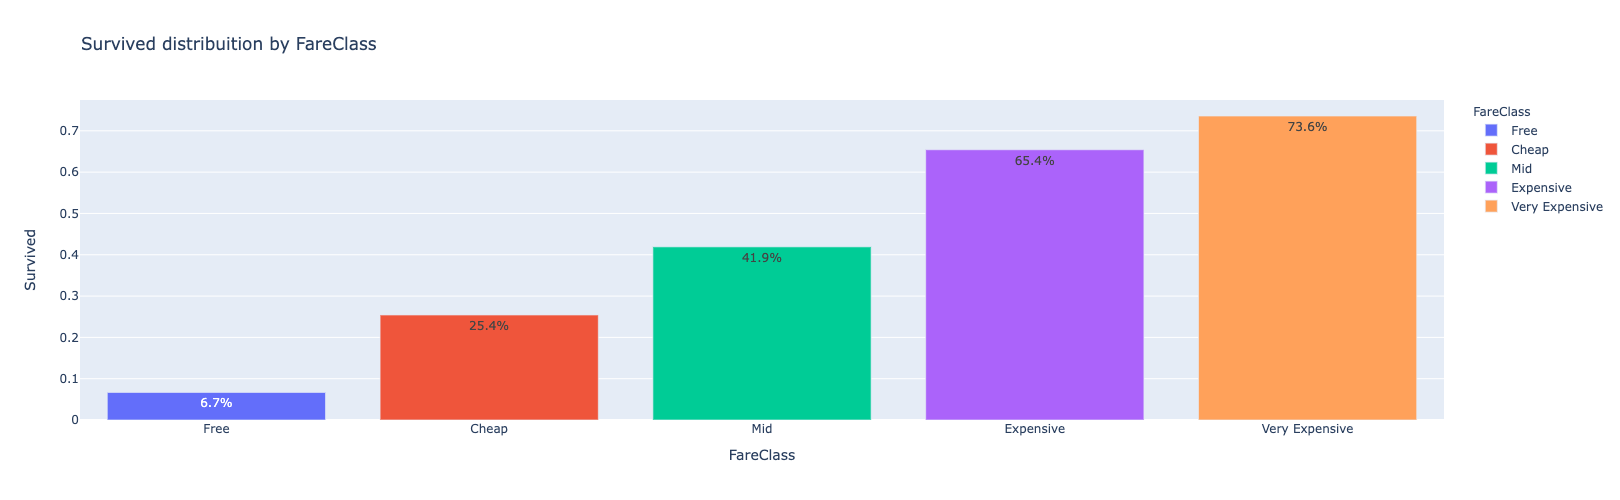

In [24]:
fig = px.bar(df.groupby(['FareClass']).mean().reset_index(),
             y="Survived",
             x="FareClass",
             color= 'FareClass',
             title="Survived distribuition by FareClass", 
             text_auto=',.1%',
             width=800, height=500)
fig.show()

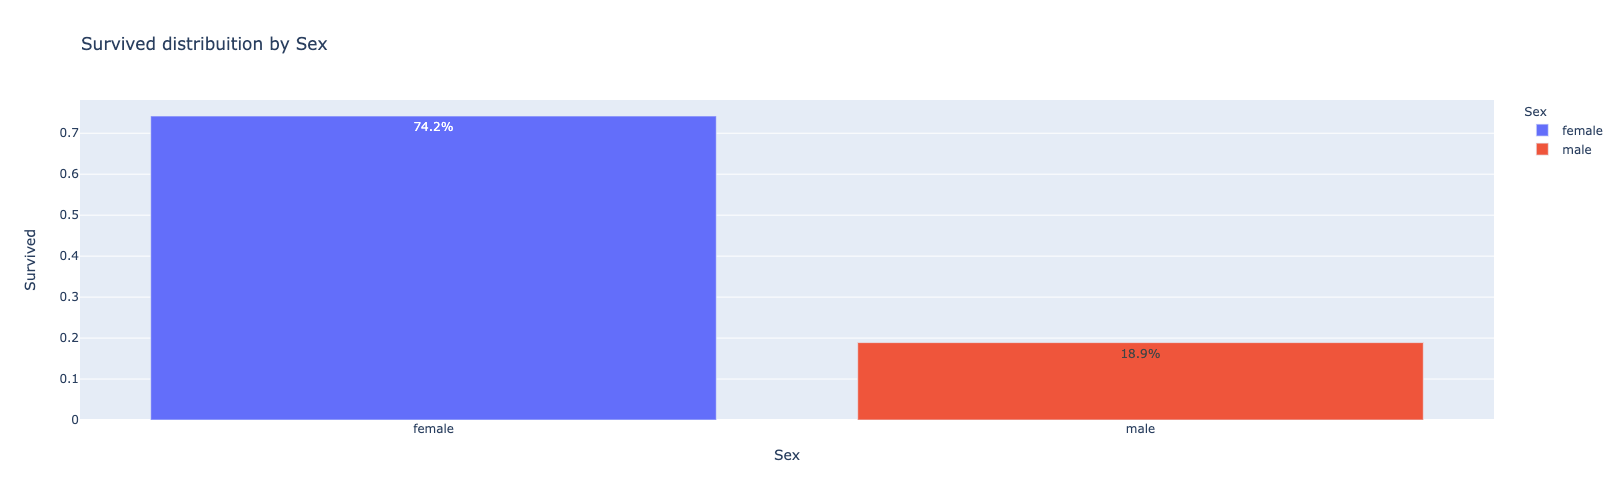

In [25]:
fig = px.bar(df.groupby(['Sex']).mean().reset_index(),
             y="Survived",
             x="Sex",
             color= 'Sex',
             title="Survived distribuition by Sex", 
             text_auto=',.1%',
             width=800, height=500)
fig.show()

## 2.6 Survival rate by sex
---

1. Women were more likely to surive (+74%) than men (+18%)

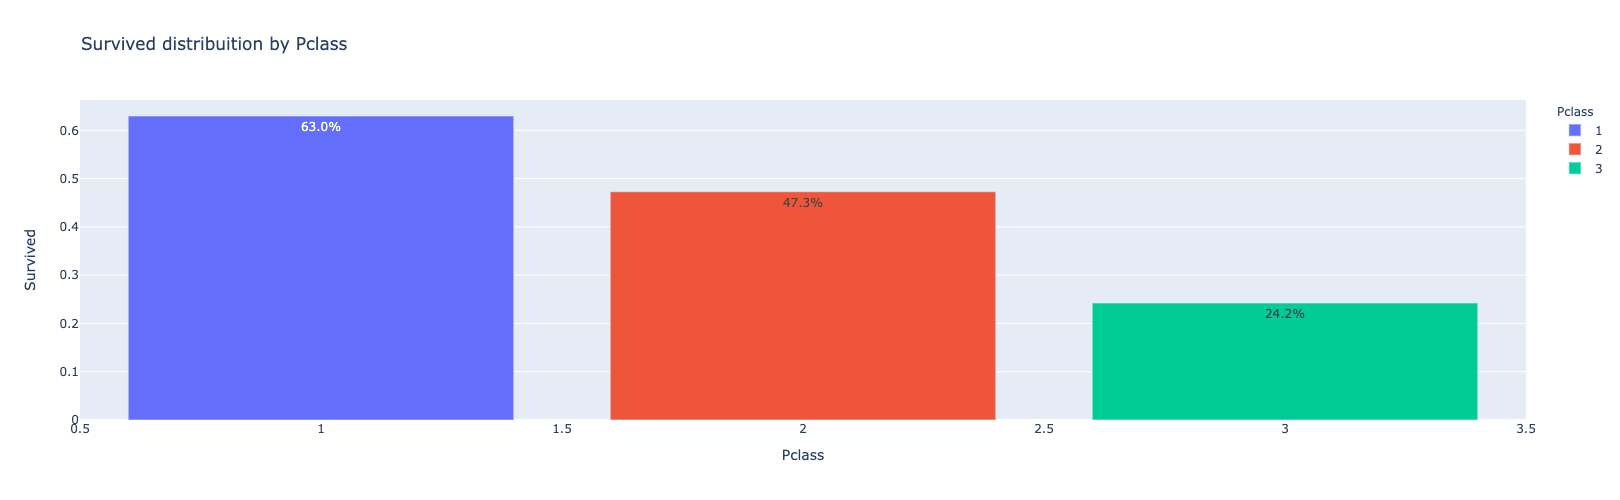

In [26]:
fig = px.bar(df.groupby(['Pclass']).mean().reset_index(),
             y="Survived",
             x="Pclass",
             color= 'Pclass',
             title="Survived distribuition by Pclass", 
             text_auto=',.1%',
             width=800, height=500)
fig.show()

## 2.7 Survival rate by Pclass
---

1. Higher status improve survival rates

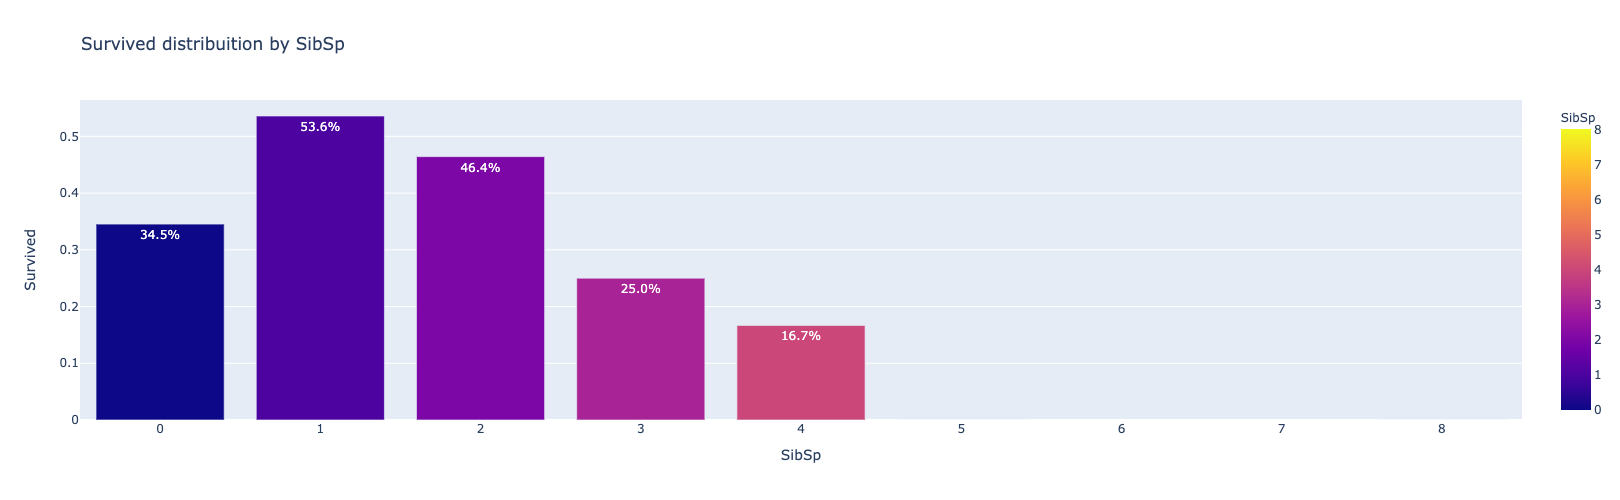

In [27]:
fig = px.bar(df.groupby(['SibSp']).mean().reset_index(),
             y="Survived",
             x="SibSp",
             color= 'SibSp',
             title="Survived distribuition by SibSp", 
             text_auto=',.1%',
             width=800, height=500)
fig.show()

## 2.8 Survival rate by SibSp
---

1. Passangers with 1 or 2 Siblins/Spouses have higher changes of surviving;
2. More than 3 Siblins/Spouses decreases the survival rates

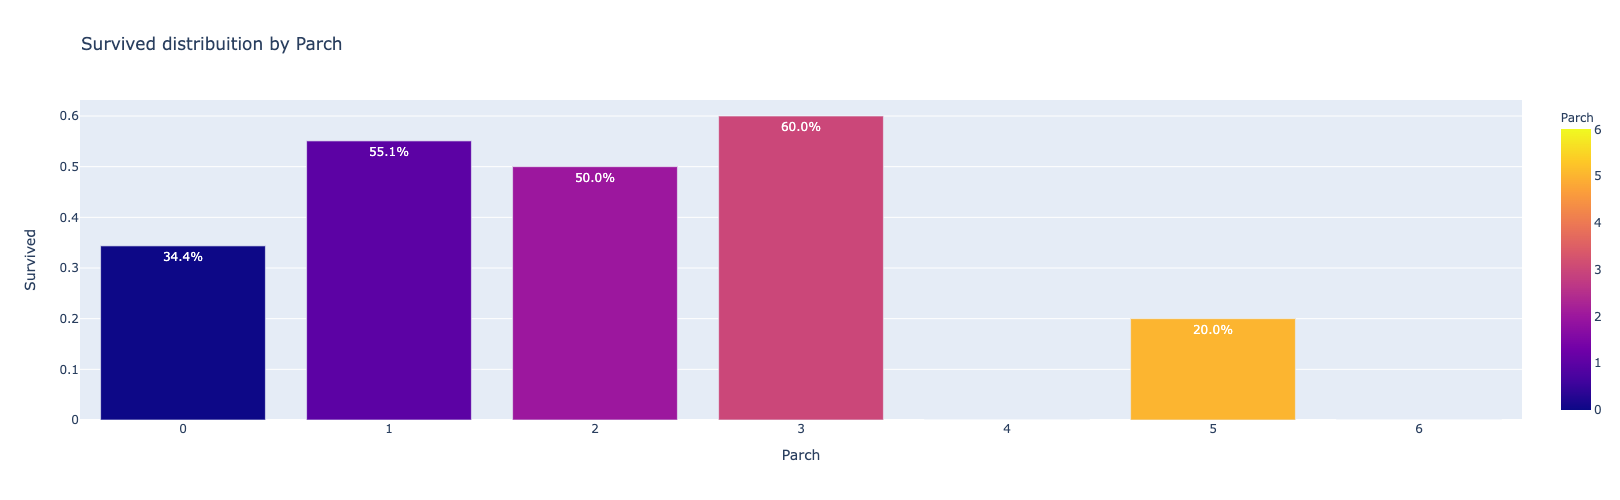

In [28]:
fig = px.bar(df.groupby(['Parch']).mean().reset_index(),
             y="Survived",
             x="Parch",
             color= 'Parch',
             title="Survived distribuition by Parch", 
             text_auto=',.1%',
             width=800, height=500)
fig.show()

## 2.9 Family feature
---

1. Let's use `Parch` and `SibSp` to create a famlily feature by summing then;
2. Then, let's create some classes

In [29]:
# Feature engineering

# Define size of the family
df['FamilySize'] = df['SibSp'] + df['Parch']

#creating the intervals that we need to cut each range of ages
interval = (0, 1, 2, 3, 10) 

#Seting the names that we want use to the categorys
cats = ['Single', 'Small Family', 'Mid Family', 'Large Family']

# Applying the pd.cut and using the parameters that we created 
df['FamilyClass'] = pd.cut(df.FamilySize, interval, labels=cats, include_lowest=True)

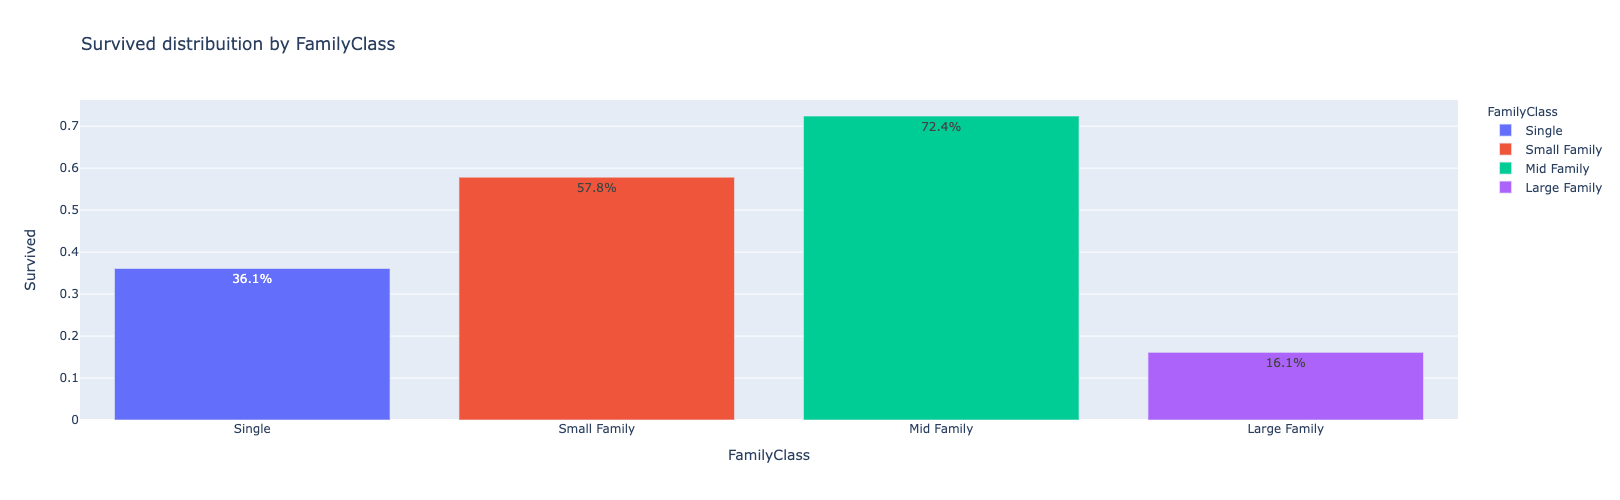

In [30]:
fig = px.bar(df.groupby(['FamilyClass']).mean().reset_index(),
             y="Survived",
             x="FamilyClass",
             color= 'FamilyClass',
             title="Survived distribuition by FamilyClass", 
             text_auto=',.1%',
             width=800, height=500)
fig.show()

## 2.10 FamilyClass
---

1. Large families have higgher changes of dead;
2. Mid Family (3 people) have the higgher survival rate (72%)

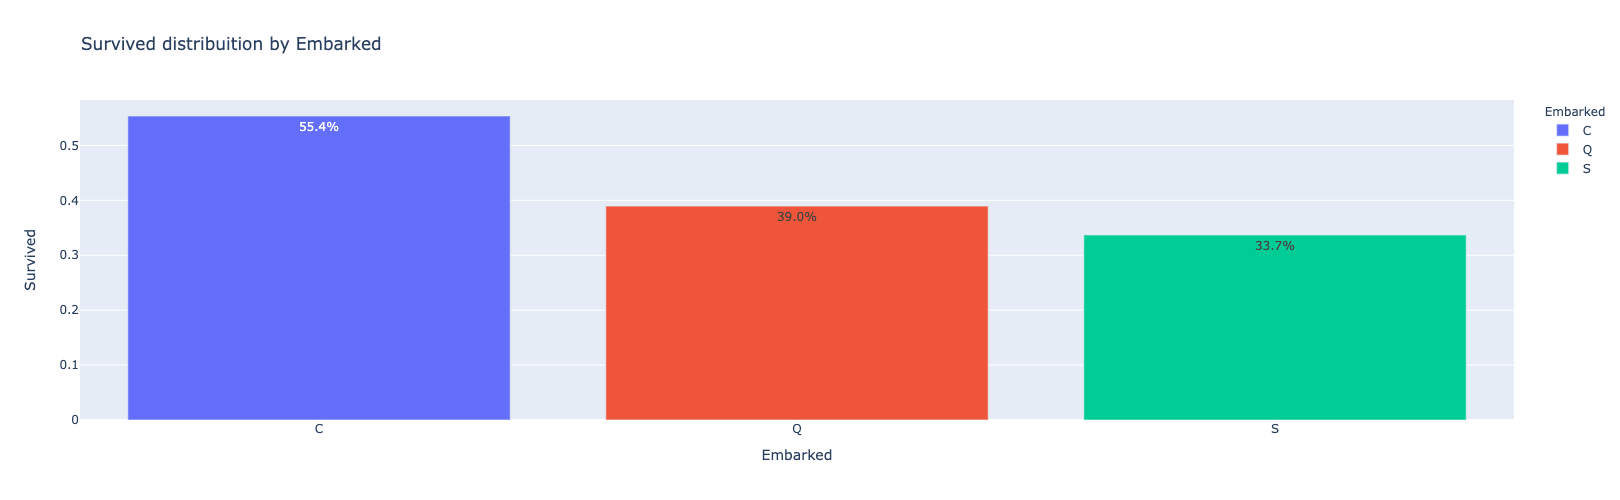

In [31]:
fig = px.bar(df.groupby(['Embarked']).mean().reset_index(),
             y="Survived",
             x="Embarked",
             color= 'Embarked',
             title="Survived distribuition by Embarked", 
             text_auto=',.1%',
             width=800, height=500)
fig.show()

## 2.11 Survival rate by Embarked
---

1. Passangers from gate C have higher survival rates (55%), then Q (39%) and then S (33%)

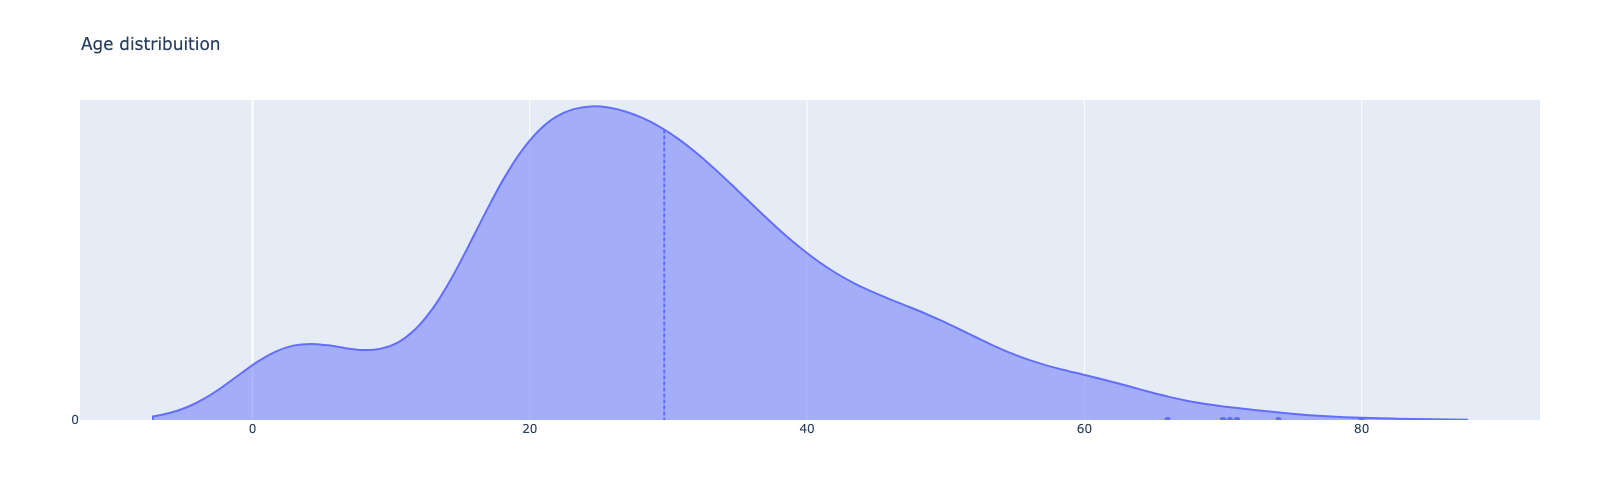

In [32]:
fig = go.Figure()
fig.add_trace(go.Violin(x=df["Age"], name='Age', y0=0))
fig.update_traces(orientation='h', side='positive', meanline_visible=True)
fig.update_layout(title='Age distribuition',
                  width=800,
                  height=500)

In [33]:
# Feature Engineering - Age
#creating the intervals that we need to cut each range of ages
interval = (0, 5, 12, 18, 25, 35, 60, 120) 

#Seting the names that we want use to the categorys
cats = ['babies', 'Children', 'Teen', 'Student', 'Young', 'Adult', 'Senior']

# Applying the pd.cut and using the parameters that we created 
df["AgeBand"] = pd.cut(df.Age, interval, labels=cats)

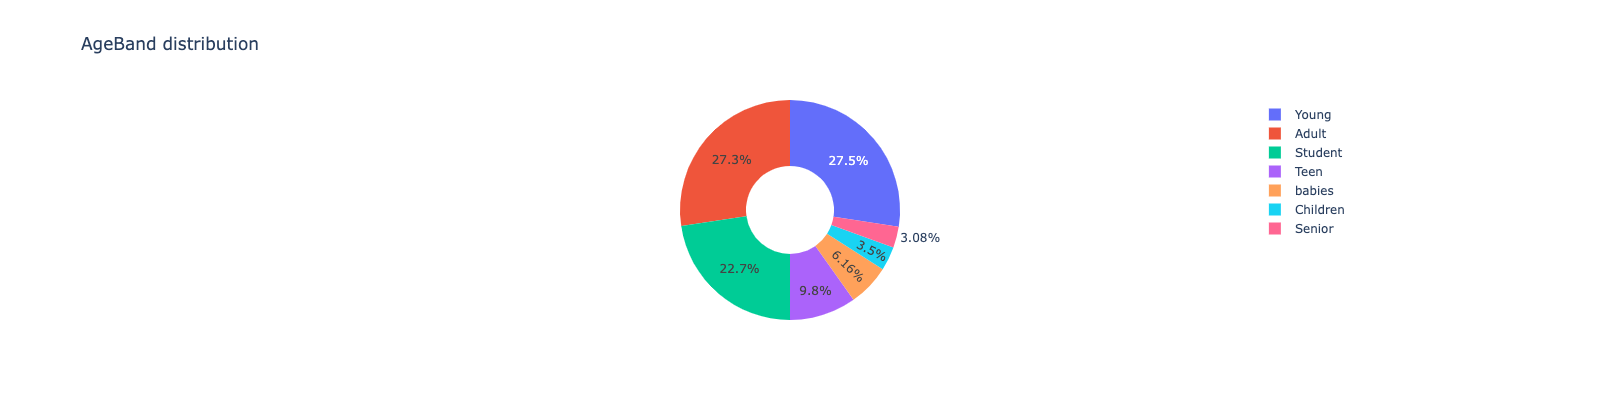

In [34]:
# Analysing AgeBand distribuition
fig = px.pie(df['AgeBand'], 
             values=df['AgeBand'].value_counts().values, 
             names=df['AgeBand'].value_counts().index,
             title="AgeBand distribution", 
             width=400, height=400, hole=0.4)
fig.show()

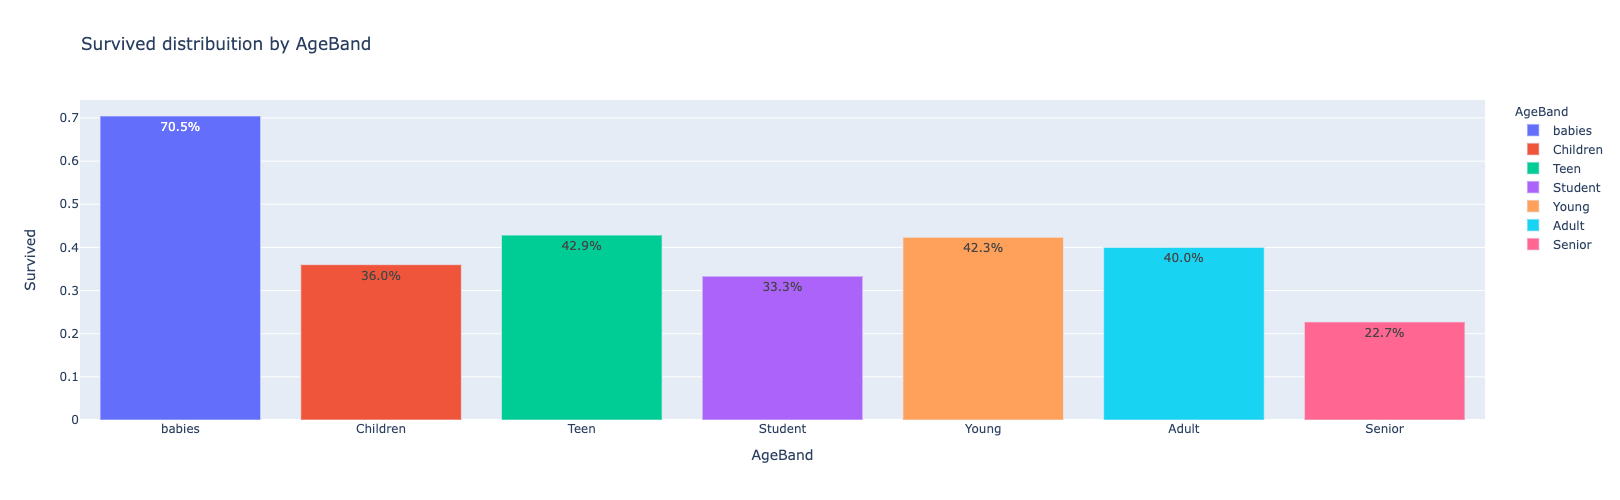

In [35]:
fig = px.bar(df.groupby(['AgeBand']).mean().reset_index(),
             y="Survived",
             x="AgeBand",
             color= 'AgeBand',
             title="Survived distribuition by AgeBand", 
             text_auto=',.1%',
             width=800, height=500)
fig.show()

## 2.12 Survival rate by Age Band
---

1. Babies have the highest survival rate (70%);
2. Seniors were more likely to die

In [36]:
# Feature Engineering - Name
df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Ms            1
Don           1
Capt          1
Sir           1
Mme           1
Countess      1
Jonkheer      1
Lady          1
Name: Title, dtype: int64

In [37]:
# Adjust Title
df.loc[df.Title.str.contains('^(?!.*(Mr|Miss|Mrs)).*$'), 'Title'] = 'Master'
df.Title.value_counts()

/opt/conda/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



Mr        517
Miss      182
Mrs       125
Master     67
Name: Title, dtype: int64

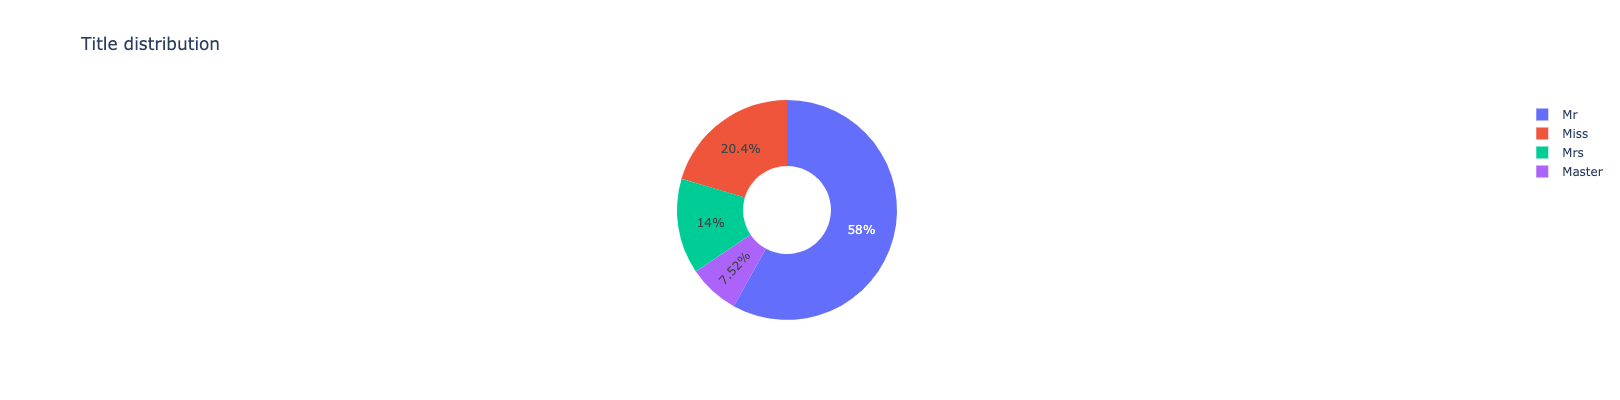

In [38]:
# Analysing Title distribuition
fig = px.pie(df['Title'], 
             values=df['Title'].value_counts().values, 
             names=df['Title'].value_counts().index,
             title="Title distribution", 
             width=400, height=400, hole=0.4)
fig.show()

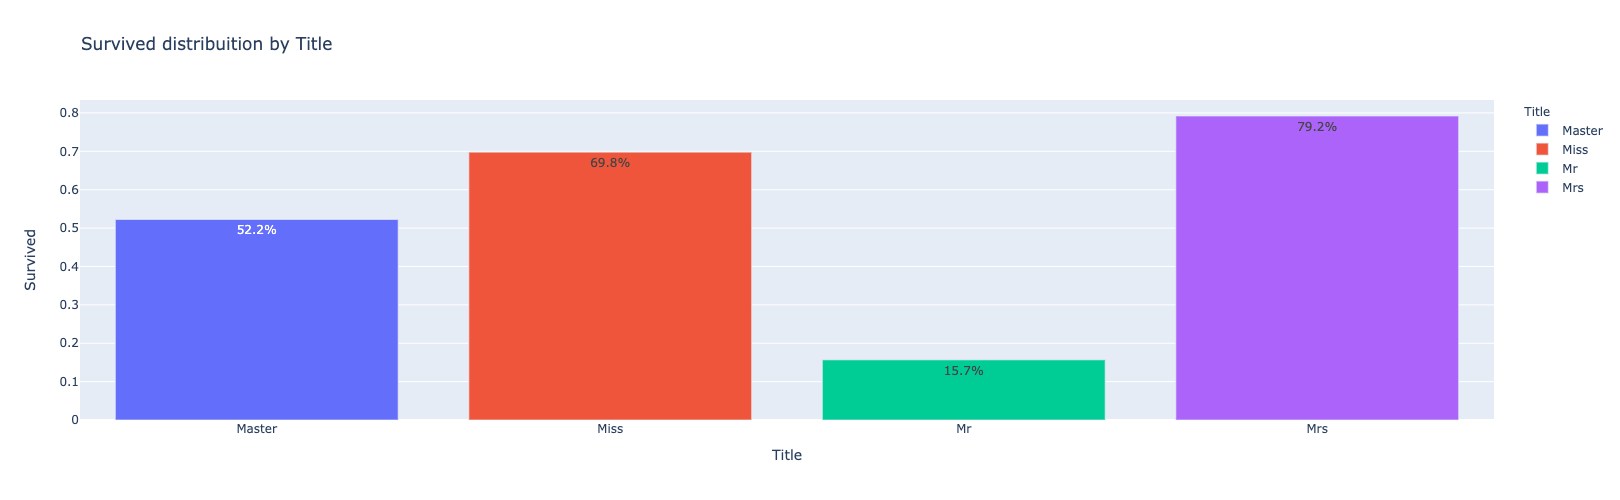

In [39]:
fig = px.bar(df.groupby(['Title']).mean().reset_index(),
             y="Survived",
             x="Title",
             color= 'Title',
             title="Survived distribuition by Title", 
             text_auto=',.1%',
             width=800, height=500)
fig.show()

## 2.13 Survival rate by Title
---

1. Mr has the lowest survival rate (15%) while Mrs has the highest (79%)

# 3. Modeling

## 3.1 Sklearn pipeline

In [148]:
class PreProcessingData(BaseEstimator, TransformerMixin):
    """Apply some preprocessing in the dataframe"""
    
    def __init__(self, columnsNames):
        self.columnsNames = columnsNames

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        self.X = X
        columnsNames = self.columnsNames
        
        df = pd.DataFrame(X, columns=columnsNames)
        
        # adjust features types
        df['Pclass'] = df['Pclass'].astype("category")
        df['Sex'] = df['Sex'].astype("category")
        df['Embarked'] = df['Embarked'].astype("category")
        
        # Let's drop PassengerId, since it'll be not relevant for the modeling
        df.drop(['PassengerId'], inplace = True, axis=1)
        
        # Cap max Fare value to treat outliers
        df['Fare'] = df['Fare'].clip(upper=165)
        
        # Feature engineering - Fare
        #creating the intervals that we need to cut each range of ages
        interval = (0, 1, 13, 50, 100, 165) 

        #Seting the names that we want use to the categorys
        cats = ['Free', 'Cheap', 'Mid', 'Expensive', 'Very Expensive']

        # Applying the pd.cut and using the parameters that we created 
        df['FareClass'] = pd.cut(df.Fare, interval, labels=cats, include_lowest=True)
        
        # Let's drop Fare
        df.drop(['Fare'], inplace = True, axis=1)
        
        # Feature engineering - Family Size

        # Define size of the family
        df['FamilySize'] = df['SibSp'] + df['Parch']

        #creating the intervals that we need to cut each range of ages
        interval = (0, 1, 2, 3, 10) 

        #Seting the names that we want use to the categorys
        cats = ['Single', 'Small Family', 'Mid Family', 'Large Family']

        # Applying the pd.cut and using the parameters that we created 
        df['FamilyClass'] = pd.cut(df.FamilySize, interval, labels=cats, include_lowest=True)
        
        # Let's drop SibSp and Parch
        df.drop(['SibSp', 'Parch', 'FamilySize'], inplace = True, axis=1)
        
        # Feature Engineering - Age
        #creating the intervals that we need to cut each range of ages
        interval = (0, 5, 12, 18, 25, 35, 60, 120) 

        #Seting the names that we want use to the categorys
        cats = ['babies', 'Children', 'Teen', 'Student', 'Young', 'Adult', 'Senior']

        # Applying the pd.cut and using the parameters that we created 
        df["AgeBand"] = pd.cut(df.Age, interval, labels=cats)
        
        # Let's drop Age
        df.drop(['Age'], inplace = True, axis=1)
        
        # Feature Engineering - Name
        df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
        df.loc[df.Title.str.contains('^(?!.*(Mr|Miss|Mrs)).*$'), 'Title'] = 'Master'
        df['Title'] = df['Title'].astype("category")
        
        # Let's drop Name
        df.drop(['Name'], inplace = True, axis=1)
        
        # Let's drop useless features
        df.drop(['Cabin', 'Ticket'], inplace = True, axis=1)
        
        return df
  
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [149]:
# Read Data Sets for modeling
df = pd.read_csv("/kaggle/input/titanic/train.csv")
submission_df = pd.read_csv("/kaggle/input/titanic/test.csv")
ids = pd.read_csv("/kaggle/input/titanic/test.csv")

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop('Survived', axis = 1), df.Survived, test_size=0.30, random_state=seed)

In [168]:
# Creating pipelines

# Numeric features
num_features = list(X_train.select_dtypes(include=['int64', 'float64']).columns)
numeric_imputer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=4, weights="uniform"))])

# Categorical features
cat_features = list(X_train.select_dtypes(include=['object', 'category']).columns)
categorical_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))])

col_features = num_features+cat_features

# Features Pipeline
features_imputer = ColumnTransformer(
    transformers=[
        ('num', numeric_imputer, num_features),
        ('cat', categorical_imputer, cat_features)])

# New Categorical features
new_cat_features = ['Pclass', 'Sex', 'Embarked', 'FareClass', 'FamilyClass', 'AgeBand', 'Title']
new_categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# New Features Pipeline
features_encoder = ColumnTransformer(
    transformers=[
        ('features', new_categorical_transformer, new_cat_features)])

# PreProcessing Pipeline
pre_processing_data = Pipeline(steps=[
    ('features_preprocessor', features_imputer),
    ('preprocessing', PreProcessingData(columnsNames = col_features)),
    ('hot_encoder', features_encoder),
    ('dimensionality_reduction', TruncatedSVD())])

In [197]:
# Creating model pipelines

# Logistic Regression
logreg_model = Pipeline(steps=[
    ('features_preprocessor', pre_processing_data),
    ('logreg', LogisticRegression(n_jobs=-1, random_state = seed))
])

# Xgboost
xgb_model = Pipeline(steps=[
    ('features_preprocessor', pre_processing_data),
    ('xgb', XGBClassifier(n_jobs=-1, random_state = seed, eval_metric="auc"))
])

# KNN
knn_model = Pipeline(steps=[
    ('features_preprocessor', pre_processing_data),
    ('knn', KNeighborsClassifier(n_jobs=-1, ))
])

# SVM
svm_model = Pipeline(steps=[
    ('features_preprocessor', pre_processing_data),
    ('svm', SVC(random_state = seed))
])

# RandomForest
rf_model = Pipeline(steps=[
    ('features_preprocessor', pre_processing_data),
    ('rf', RandomForestClassifier(n_jobs=-1, random_state = seed))
])

# Naive Bayes
nb_model = Pipeline(steps=[
    ('features_preprocessor', pre_processing_data),
    ('nb', GaussianNB())
])



In [198]:
# Hyper parameters grid

# Logistic Regression
logreg_grid = {
        'logreg__solver': hp.choice('logreg__solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
        'logreg__penalty': hp.choice('logreg__penalty', ['l1', 'elasticnet','l2', 'none']),
        'logreg__fit_intercept': hp.choice('logreg__fit_intercept', [True, False]),
        'logreg__C': hp.loguniform('logreg__C', -4.0*np.log(10.0), 4.0*np.log(10.0)), 
        'logreg__tol': hp.lognormal('logreg__tol', 1e-4, 0.5),
        "features_preprocessor__dimensionality_reduction__n_components": scope.int(hp.quniform('features_preprocessor__num__lda__n_components', 1, 30, 1))
}

# Xgboost
xgb_grid = {
    "xgb__objective": hp.choice("xgb__objective", ['binary:logistic', 'binary:logitraw', 'binary:hinge']),
    "xgb__learning_rate": hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    "xgb__colsample_bytree": hp.uniform('xgb__colsample_bytree', 0, 1),
    "xgb__colsample_bylevel": hp.uniform('xgb__colsample_bylevel', 0, 1),
    "xgb__colsample_bynode": hp.uniform('xgb__colsample_bynode', 0, 1),
    "xgb__subsample": hp.uniform('xgb__subsample', 0, 1),
    "xgb__max_depth": scope.int(hp.quniform('xgb__max_depth', 1, 25, 1)),
    "xgb__n_estimators": scope.int(hp.quniform('xgb__n_estimators', 1, 3000, 10)),
    "xgb__reg_alpha": hp.uniform('xgb__reg_alpha', 0, 1),
    "xgb__reg_lambda": hp.uniform('xgb__reg_lambda', 0, 1),
    "xgb__gamma": hp.uniform('xgb__gamma', 0, 30),
    "features_preprocessor__dimensionality_reduction__n_components": scope.int(hp.quniform('features_preprocessor__num__lda__n_components', 1, 30, 1))
}

# KNN
knn_grid = {
        'knn__leaf_size' : scope.int(hp.quniform('knn__leaf_size', 1, 60, 1)),
        'knn__n_neighbors': scope.int(hp.quniform('knn__n_neighbors', 1, 30, 1)),
        'knn__weights': hp.choice('knn__weights', ['uniform', 'distance']),
        'knn__metric': hp.choice('knn__metric', ['euclidean', 'manhattan', 'minkowski']),
        "features_preprocessor__dimensionality_reduction__n_components": scope.int(hp.quniform('features_preprocessor__num__lda__n_components', 1, 30, 1))
}

# SVM
svm_grid = {
        'svm__kernel': hp.choice('svm__kernel', ['poly', 'rbf', 'sigmoid', 'linear']),
        'svm__degree': scope.int(hp.quniform('svm__degree', 1, 15, 1)),
        'svm__C': hp.uniform('svm__C', 0.001, 2),
        'svm__gamma': hp.choice('svm__gamma', ['scale', 'auto']),
        "features_preprocessor__dimensionality_reduction__n_components": scope.int(hp.quniform('features_preprocessor__num__lda__n_components', 1, 30, 1))
}


# RandomForest
rf_grid = {
        'rf__n_estimators': scope.int(hp.quniform('rf__n_estimators', 1, 3000, 10)),
        'rf__criterion': hp.choice('rf__criterion', ['gini', 'entropy']),
        'rf__max_features': hp.choice('rf__max_features', ['auto', 'sqrt', 'log2']),
        'rf__max_depth': scope.int(hp.quniform('rf__max_depth', 1, 25, 1)),
        'rf__min_samples_split': scope.int(hp.quniform('rf__min_samples_split', 1, 20, 1)),
        'rf__min_samples_leaf': scope.int(hp.quniform('rf__min_samples_leaf', 1, 20, 1)),
        'rf__max_leaf_nodes': scope.int(hp.quniform('rf__max_leaf_nodes', 0, 15, 1)),
        "features_preprocessor__dimensionality_reduction__n_components": scope.int(hp.quniform('features_preprocessor__num__lda__n_components', 1, 30, 1))
}


In [207]:
# Function to test all pipelines we have defined and tune the models with bayesian approach

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    scoring_df = []
    models = [
              ('Logistic Regression', logreg_model, logreg_grid),
              ('XGBoost', xgb_model, xgb_grid),
              ('KNN', knn_model, knn_grid)
    ]
                
    results = []
    names = []
    
    final_scoring = {}
    final_parameters = {}
    target_names = list(map(str, y_train.unique()))
        
    # silent process
    import warnings
    warnings.filterwarnings('ignore') 

    for name, model, space in models:
        
        # objective funtion 
        def objective(params):

            # parameters from pipeline
            model.set_params(**params)

            # K fold CV
            shuffle = KFold(n_splits=5, shuffle=True, random_state = seed)

            # calculate eval metric
            score = cross_val_score(model, X_train, y_train, cv=shuffle, scoring='f1_weighted', n_jobs=-1, error_score = 0)

            # return the negative mean of the eval metric
            return {
            'loss': -score.mean(),  
            'status': STATUS_OK
        }

        print('**** Inicializing the hyperparameter tuning of {} ****'.format(name))
              
        # The Trials object will store details of each iteration
        trials = Trials()

        # Run the hyperparameter search using the tpe algorithm
        best = fmin(objective,
                    space,
                    algo=tpe.suggest,
                    max_evals=500,
                    trials=trials,
                    rstate= np.random.RandomState(seed))
            
        # Get the values of the optimal parameters
        best_params = space_eval(space, best)
        
        print('**** The best parameters for {} are: {} ****'.format(name, best_params))

        # Fit the model with the optimal hyperparamters
        model.set_params(**best_params)
        model.fit(X_train, y_train)
        
        final_scoring['model'] = name 
        
        model_tuned = 'best_params_{}'.format(name)
        final_parameters[model_tuned] = best_params
              
        # train scores
        y_pred = model.predict(X_train)
        print('**** Training classification report for {} model ****'.format(name))
        print(classification_report(y_train, y_pred, target_names=target_names))
        
        # test scores
        y_pred = model.predict(X_test)
        print('**** Test classification report for {} model ****'.format(name))
        print(classification_report(y_test, y_pred, target_names=target_names))
        
        # train scores
        y_pred = model.predict(X_train)
        final_scoring['train_accuracy'] = np.round(np.array([accuracy_score(y_train, y_pred)]),4)
        final_scoring['train_precision'] = np.round(np.array([precision_score(y_train, y_pred)]),4)
        final_scoring['train_recall'] = np.round(np.array([recall_score(y_train, y_pred)]),4)
        final_scoring['train_f1_score'] = np.round(np.array([f1_score(y_train, y_pred)]),4)
        
        # test scores
        y_pred = model.predict(X_test)
        final_scoring['test_accuracy'] = np.round(np.array([accuracy_score(y_test, y_pred)]),4)
        final_scoring['test_precision'] = np.round(np.array([precision_score(y_test, y_pred)]),4)
        final_scoring['test_recall'] = np.round(np.array([recall_score(y_test, y_pred)]),4)
        final_scoring['test_f1_score'] = np.round(np.array([f1_score(y_test, y_pred)]),4)
        
        # Get all models train scores
        this_df = pd.DataFrame(final_scoring)
        scoring_df.append(this_df)

        train_final_score = pd.concat(scoring_df, ignore_index=True)

    return train_final_score, final_parameters

In [208]:
train_final_score, final_parameters = run_exps(X_train, y_train, X_test, y_test)
# best_params = run_exps(X_train, y_train, X_test, y_test)

**** Inicializing the hyperparameter tuning of Logistic Regression ****
100%|██████████| 500/500 [03:08<00:00,  2.65trial/s, best loss: -0.8382207965893658]
**** The best parameters for Logistic Regression are: {'features_preprocessor__dimensionality_reduction__n_components': 22, 'logreg__C': 0.6616815314918516, 'logreg__fit_intercept': False, 'logreg__penalty': 'l1', 'logreg__solver': 'saga', 'logreg__tol': 0.4816471257890711} ****
**** Training classification report for Logistic Regression model ****
              precision    recall  f1-score   support

           1       0.85      0.91      0.88       392
           0       0.83      0.72      0.77       231

    accuracy                           0.84       623
   macro avg       0.84      0.81      0.82       623
weighted avg       0.84      0.84      0.84       623

**** Test classification report for Logistic Regression model ****
              precision    recall  f1-score   support

           1       0.80      0.89      0.84

In [209]:
train_final_score.sort_values(by = 'test_f1_score', ascending=False)

,model,train_accuracy,train_precision,train_recall,train_f1_score,test_accuracy,test_precision,test_recall,test_f1_score
1,XGBoost,0.8764,0.9053,0.7446,0.8171,0.8246,0.8265,0.7297,0.7751
2,KNN,0.8443,0.8454,0.7100,0.7718,0.8097,0.8191,0.6937,0.7512
0,Logistic Regression,0.8395,0.8259,0.7186,0.7685,0.8060,0.8105,0.6937,0.7476


In [210]:
final_parameters

{'best_params_Logistic Regression': {'features_preprocessor__dimensionality_reduction__n_components': 22,
  'logreg__C': 0.6616815314918516,
  'logreg__fit_intercept': False,
  'logreg__penalty': 'l1',
  'logreg__solver': 'saga',
  'logreg__tol': 0.4816471257890711},
 'best_params_XGBoost': {'features_preprocessor__dimensionality_reduction__n_components': 16,
  'xgb__colsample_bylevel': 0.3706480221821732,
  'xgb__colsample_bynode': 0.8545405275616711,
  'xgb__colsample_bytree': 0.8571470014493988,
  'xgb__gamma': 3.1280633767677406,
  'xgb__learning_rate': 0.014118037575277749,
  'xgb__max_depth': 9,
  'xgb__n_estimators': 1090,
  'xgb__objective': 'binary:logistic',
  'xgb__reg_alpha': 0.3725902262348746,
  'xgb__reg_lambda': 0.40949293347758187,
  'xgb__subsample': 0.39575793351409233},
 'best_params_KNN': {'features_preprocessor__dimensionality_reduction__n_components': 21,
  'knn__leaf_size': 41,
  'knn__metric': 'minkowski',
  'knn__n_neighbors': 13,
  'knn__weights': 'uniform'}}

In [211]:
# Stacking

from sklearn.ensemble import StackingClassifier

# Get tunned parameters from the best models 
xgb_model.set_params(**final_parameters['best_params_XGBoost'])
logreg_model.set_params(**final_parameters['best_params_Logistic Regression'])
knn_model.set_params(**final_parameters['best_params_KNN']) 

# 10 Fold CV
shuffle = KFold(n_splits=10, 
                shuffle=True, 
                random_state = seed)

# Define the best models to be stacked
estimators = [
    ('XGBoost', xgb_model),
    ('LR', logreg_model),
    ('KNN', knn_model)]

# Create the meta-model
clf = StackingClassifier(estimators=estimators, 
                        final_estimator=LogisticRegression(),
                        cv = shuffle)

# Fitting the meta-model
clf.fit(X_train, y_train)
target_names = list(map(str, y_train.unique()))

# Print results
print(classification_report(y_train, clf.predict(X_train), target_names=target_names))
print(classification_report(y_test, clf.predict(X_test), target_names=target_names))

              precision    recall  f1-score   support

           1       0.86      0.95      0.90       392
           0       0.89      0.74      0.81       231

    accuracy                           0.87       623
   macro avg       0.88      0.85      0.86       623
weighted avg       0.87      0.87      0.87       623

              precision    recall  f1-score   support

           1       0.81      0.90      0.86       157
           0       0.84      0.70      0.76       111

    accuracy                           0.82       268
   macro avg       0.83      0.80      0.81       268
weighted avg       0.82      0.82      0.82       268



In [215]:
# Voting

from sklearn.ensemble import VotingClassifier

# Get tunned parameters from the best models 
xgb_model.set_params(**final_parameters['best_params_XGBoost'])
logreg_model.set_params(**final_parameters['best_params_Logistic Regression'])
knn_model.set_params(**final_parameters['best_params_KNN'])
# svm_model.set_params(**final_parameters['best_params_SVM'])

# Define the best models to be stacked
estimators = [
    ('XGBoost', xgb_model),
    ('LR', logreg_model),
    ('KNN', knn_model)]

# Create the meta-model
ensemble_model = VotingClassifier(estimators = estimators, 
                                  voting = "hard")

# Fitting the meta-model
ensemble_model.fit(X_train, y_train)
target_names = list(map(str, y_train.unique()))

# Print results
print(classification_report(y_train, ensemble_model.predict(X_train), target_names=target_names))
print(classification_report(y_test, ensemble_model.predict(X_test), target_names=target_names))

              precision    recall  f1-score   support

           1       0.85      0.94      0.89       392
           0       0.87      0.73      0.79       231

    accuracy                           0.86       623
   macro avg       0.86      0.83      0.84       623
weighted avg       0.86      0.86      0.86       623

              precision    recall  f1-score   support

           1       0.80      0.90      0.85       157
           0       0.84      0.68      0.75       111

    accuracy                           0.81       268
   macro avg       0.82      0.79      0.80       268
weighted avg       0.82      0.81      0.81       268



In [216]:
# Get full data set
X_full = X_train.append(X_test)
y_full = y_train.append(y_test)

# Fitting the meta-model to the full data set
clf.fit(X_full, y_full)

StackingClassifier(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimators=[('XGBoost',
                                Pipeline(memory=None,
                                         steps=[('features_preprocessor',
                                                 Pipeline(memory=None,
                                                          steps=[('features_preprocessor',
                                                                  ColumnTransformer(n_jobs=None,
                                                                                    remainder='drop',
                                                                                    sparse_threshold=0.3,
                                                                                    transformer_weights=None,
                                                                                    transformers=[('num',
                                                                         

In [217]:
results = pd.DataFrame()
results['PassengerId'] = ids.PassengerId
results['Survived'] = clf.predict(submission_df)

In [218]:
results

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [219]:
results.to_csv("final_submission.csv", index=False)